# Hazard Modeling and Incident Generation

This notebook explores the hazard-based approach to generating healthcare incidents, converting annual risks to timestep probabilities as described in the Healthcare AI Temporal Simulation Framework.

## Key Concepts

1. **Hazard Functions**: Mathematical representation of instantaneous risk
2. **Risk to Hazard Conversion**: Transform annual probabilities to continuous hazard rates
3. **Discrete Time Approximation**: Convert hazards to timestep probabilities
4. **Incident Generation**: Stochastic process respecting individual risk levels

## Learning Objectives

- Understand the relationship between risk, hazard, and probability
- Implement exact mathematical conversions for different time scales
- Validate incident generation matches expected rates
- Compare discrete vs continuous time approaches

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
from scipy.special import expit
import pickle

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load functions from previous notebooks
try:
    with open('risk_distribution_functions.pkl', 'rb') as f:
        risk_functions = pickle.load(f)
    assign_patient_risks = risk_functions['assign_patient_risks']
    
    with open('temporal_risk_functions.pkl', 'rb') as f:
        temporal_functions = pickle.load(f)
    TemporalRiskSimulator = temporal_functions['TemporalRiskSimulator']
    
    print("Loaded functions from previous notebooks.")
except:
    print("Warning: Could not load functions from previous notebooks. Defining locally.")
     # Define it here if the file doesn't exist
    def assign_patient_risks(n_patients, annual_incident_rate, concentration=0.5, random_seed=None):
        if random_seed is not None:
            np.random.seed(random_seed)
        
        alpha = concentration
        beta_param = alpha * (1/annual_incident_rate - 1)
        raw_risks = np.random.beta(alpha, beta_param, n_patients)
        scaling_factor = annual_incident_rate / np.mean(raw_risks)
        base_annual_risks = np.clip(raw_risks * scaling_factor, 0, 0.99)
        
        return base_annual_risks

    
    print("Defined risk assignment function locally.")
    # Define minimal versions here if needed
    

Defined risk assignment function locally.


In [11]:
temporal_functions = pickle.load(f)

ValueError: peek of closed file

## 1. Understanding Hazard Functions

In survival analysis, we distinguish between:
- **Risk/Probability**: P(event by time T)
- **Hazard Rate**: Instantaneous probability of event at time t, given survival to t
- **Survival Function**: S(t) = P(no event by time t) = 1 - Risk(t)

The relationship: $S(t) = e^{-\int_0^t h(u)du}$

For constant hazard: $S(t) = e^{-ht}$

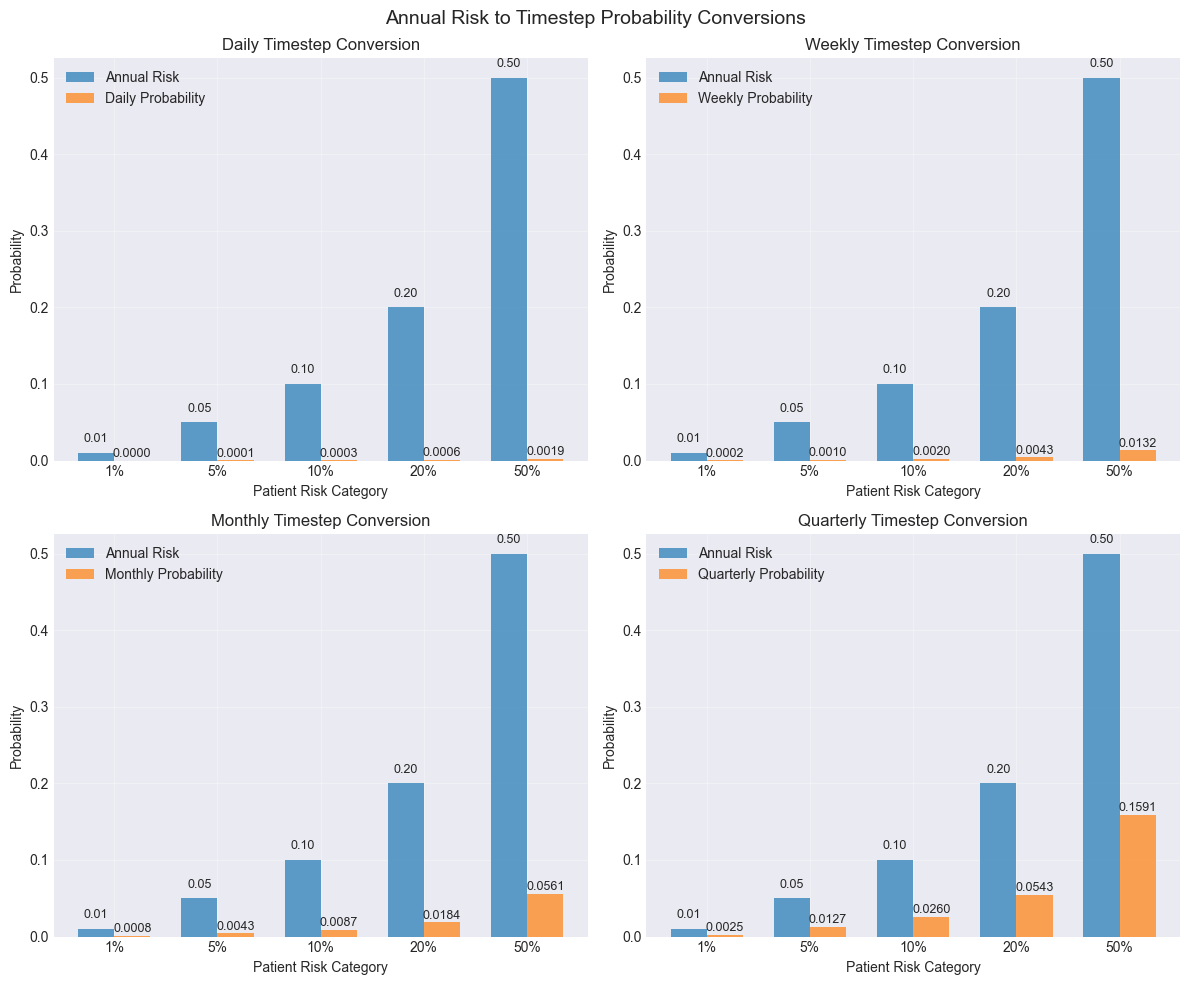


Conversion Summary:
Annual Risk → Annual Hazard: h = -ln(1 - p)
Annual Hazard → Timestep Prob: p_timestep = 1 - exp(-h * Δt)

Direct formula: p_timestep = 1 - (1 - p_annual)^Δt


In [9]:
def annual_risk_to_hazard(annual_risk):
    """
    Convert annual risk (probability) to constant hazard rate.
    
    Parameters:
    -----------
    annual_risk : float or np.ndarray
        Probability of event within one year
        
    Returns:
    --------
    annual_hazard : float or np.ndarray
        Constant hazard rate (events per year)
    """
    # From survival function: S(1 year) = 1 - annual_risk = exp(-h * 1)
    # Therefore: h = -ln(1 - annual_risk)
    return -np.log(1 - annual_risk)

def hazard_to_timestep_probability(hazard, timestep_duration):
    """
    Convert hazard rate to probability for a specific timestep.
    
    Parameters:
    -----------
    hazard : float or np.ndarray
        Hazard rate (events per unit time)
    timestep_duration : float
        Duration of timestep in same units as hazard
        
    Returns:
    --------
    timestep_prob : float or np.ndarray
        Probability of event during timestep
    """
    # P(event in timestep) = 1 - exp(-hazard * duration)
    return 1 - np.exp(-hazard * timestep_duration)

# Demonstrate the conversions
annual_risks = np.array([0.01, 0.05, 0.10, 0.20, 0.50])
annual_hazards = annual_risk_to_hazard(annual_risks)

# Convert to different timesteps
timesteps = {
    'Daily': 1/365,
    'Weekly': 1/52,
    'Monthly': 1/12,
    'Quarterly': 1/4
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (timestep_name, timestep_duration) in enumerate(timesteps.items()):
    ax = axes[idx]
    
    timestep_probs = hazard_to_timestep_probability(annual_hazards, timestep_duration)
    
    # Create comparison table
    x = np.arange(len(annual_risks))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, annual_risks, width, label='Annual Risk', alpha=0.7)
    bars2 = ax.bar(x + width/2, timestep_probs, width, label=f'{timestep_name} Probability', alpha=0.7)
    
    # Add value labels
    for bar1, bar2, risk, prob in zip(bars1, bars2, annual_risks, timestep_probs):
        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01,
                f'{risk:.2f}', ha='center', va='bottom', fontsize=9)
        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.001,
                f'{prob:.4f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Patient Risk Category')
    ax.set_ylabel('Probability')
    ax.set_title(f'{timestep_name} Timestep Conversion')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{r:.0%}' for r in annual_risks])
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Annual Risk to Timestep Probability Conversions', fontsize=14)
plt.tight_layout()
plt.show()

# Display exact conversion formulas
print("\nConversion Summary:")
print("==================")
print("Annual Risk → Annual Hazard: h = -ln(1 - p)")
print("Annual Hazard → Timestep Prob: p_timestep = 1 - exp(-h * Δt)")
print("\nDirect formula: p_timestep = 1 - (1 - p_annual)^Δt")

## 2. Hazard Function Properties

Let's explore key properties of hazard functions and their implications for healthcare modeling.

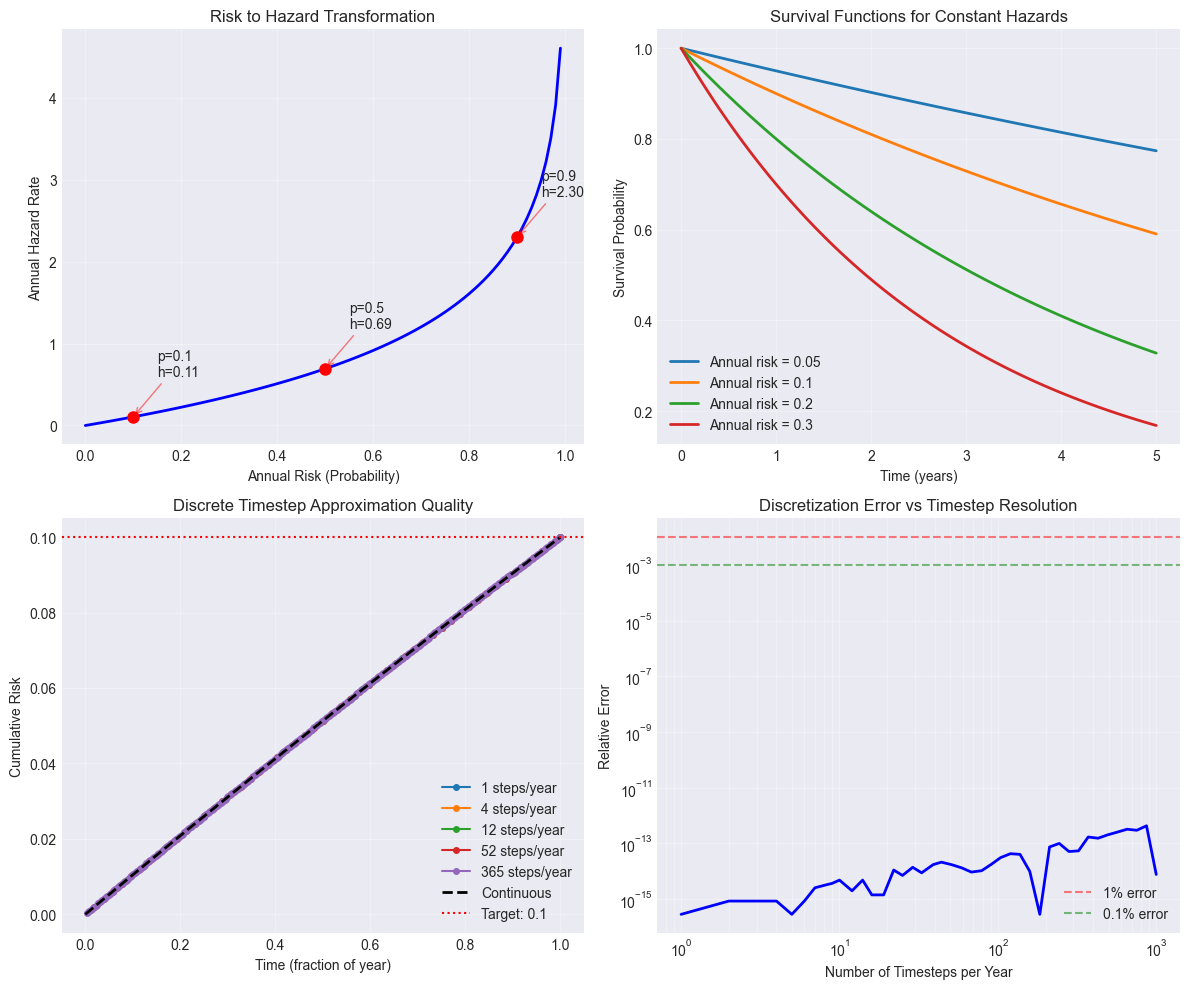

In [3]:
def explore_hazard_properties():
    """
    Visualize key properties of hazard functions.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Risk vs Hazard relationship
    ax = axes[0, 0]
    risks = np.linspace(0, 0.99, 100)
    hazards = annual_risk_to_hazard(risks)
    
    ax.plot(risks, hazards, 'b-', linewidth=2)
    ax.set_xlabel('Annual Risk (Probability)')
    ax.set_ylabel('Annual Hazard Rate')
    ax.set_title('Risk to Hazard Transformation')
    ax.grid(True, alpha=0.3)
    
    # Add annotations for key points
    for risk_point in [0.1, 0.5, 0.9]:
        hazard_point = annual_risk_to_hazard(risk_point)
        ax.plot(risk_point, hazard_point, 'ro', markersize=8)
        ax.annotate(f'p={risk_point}\nh={hazard_point:.2f}',
                   xy=(risk_point, hazard_point),
                   xytext=(risk_point + 0.05, hazard_point + 0.5),
                   arrowprops=dict(arrowstyle='->', color='red', alpha=0.5))
    
    # 2. Survival curves for different hazards
    ax = axes[0, 1]
    time = np.linspace(0, 5, 100)  # 5 years
    
    for annual_risk in [0.05, 0.1, 0.2, 0.3]:
        hazard = annual_risk_to_hazard(annual_risk)
        survival = np.exp(-hazard * time)
        ax.plot(time, survival, linewidth=2, label=f'Annual risk = {annual_risk}')
    
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Survival Probability')
    ax.set_title('Survival Functions for Constant Hazards')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Discrete vs continuous approximation error
    ax = axes[1, 0]
    
    annual_risk = 0.1
    hazard = annual_risk_to_hazard(annual_risk)
    
    # Different timestep sizes
    n_steps_list = [1, 4, 12, 52, 365]  # Annual, quarterly, monthly, weekly, daily
    
    for n_steps in n_steps_list:
        timestep = 1.0 / n_steps
        timestep_prob = hazard_to_timestep_probability(hazard, timestep)
        
        # Simulate cumulative risk over 1 year
        cumulative_risks = []
        for n in range(1, n_steps + 1):
            # Probability of at least one event in n timesteps
            cum_risk = 1 - (1 - timestep_prob)**n
            cumulative_risks.append(cum_risk)
        
        time_points = np.arange(1, n_steps + 1) / n_steps
        ax.plot(time_points, cumulative_risks, 'o-', 
                label=f'{n_steps} steps/year', markersize=4)
    
    # Add continuous curve
    continuous_time = np.linspace(0, 1, 100)
    continuous_risk = 1 - np.exp(-hazard * continuous_time)
    ax.plot(continuous_time, continuous_risk, 'k--', 
            linewidth=2, label='Continuous')
    
    ax.axhline(annual_risk, color='red', linestyle=':', 
               label=f'Target: {annual_risk}')
    ax.set_xlabel('Time (fraction of year)')
    ax.set_ylabel('Cumulative Risk')
    ax.set_title('Discrete Timestep Approximation Quality')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Approximation error analysis
    ax = axes[1, 1]
    
    n_steps_range = np.logspace(0, 3, 50).astype(int)  # 1 to 1000 steps/year
    approximation_errors = []
    
    for n_steps in n_steps_range:
        timestep = 1.0 / n_steps
        timestep_prob = hazard_to_timestep_probability(hazard, timestep)
        
        # Discrete approximation of annual risk
        discrete_annual_risk = 1 - (1 - timestep_prob)**n_steps
        
        # Relative error
        error = abs(discrete_annual_risk - annual_risk) / annual_risk
        approximation_errors.append(error)
    
    ax.loglog(n_steps_range, approximation_errors, 'b-', linewidth=2)
    ax.set_xlabel('Number of Timesteps per Year')
    ax.set_ylabel('Relative Error')
    ax.set_title('Discretization Error vs Timestep Resolution')
    ax.grid(True, alpha=0.3, which='both')
    
    # Add reference lines
    ax.axhline(0.01, color='red', linestyle='--', alpha=0.5, label='1% error')
    ax.axhline(0.001, color='green', linestyle='--', alpha=0.5, label='0.1% error')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

explore_hazard_properties()

## 3. Incident Generation Process

Now let's implement the complete incident generation process that:
1. Takes time-varying risks
2. Applies intervention effects
3. Converts to timestep probabilities
4. Generates stochastic incidents

In [6]:
class IncidentGenerator:
    """
    Generates healthcare incidents based on individual patient risks.
    """
    
    def __init__(self, timestep_duration=1/52):  # Default: weekly
        """
        Initialize incident generator.
        
        Parameters:
        -----------
        timestep_duration : float
            Duration of each timestep as fraction of year (1/52 for weekly)
        """
        self.timestep_duration = timestep_duration
        self.incident_history = []
        self.cumulative_incidents = None
    
    def generate_incidents(self, annual_risks, intervention_mask=None, 
                         intervention_effectiveness=0.0):
        """
        Generate incidents for one timestep.
        
        Parameters:
        -----------
        annual_risks : np.ndarray
            Current annual risk for each patient
        intervention_mask : np.ndarray, optional
            Boolean mask indicating which patients receive intervention
        intervention_effectiveness : float
            Relative risk reduction for treated patients (0.0 to 1.0)
            
        Returns:
        --------
        incidents : np.ndarray
            Boolean array indicating which patients had incidents
        """
        n_patients = len(annual_risks)
        
        # Apply intervention effect
        modified_risks = annual_risks.copy()
        if intervention_mask is not None:
            modified_risks[intervention_mask] *= (1 - intervention_effectiveness)
        
        # Convert to hazards
        annual_hazards = annual_risk_to_hazard(modified_risks)
        
        # Convert to timestep probabilities
        timestep_probs = hazard_to_timestep_probability(annual_hazards, 
                                                       self.timestep_duration)
        
        # Generate incidents
        random_draws = np.random.uniform(0, 1, n_patients)
        incidents = random_draws < timestep_probs
        
        # Update history
        self.incident_history.append(incidents)
        
        # Update cumulative incidents
        if self.cumulative_incidents is None:
            self.cumulative_incidents = incidents.astype(int)
        else:
            # Only count first incident per patient
            new_incidents = incidents & (self.cumulative_incidents == 0)
            self.cumulative_incidents += new_incidents.astype(int)
        
        return incidents
    
    def get_cumulative_incidence(self):
        """
        Get cumulative incidence rate.
        """
        if self.cumulative_incidents is None:
            return 0.0
        return np.mean(self.cumulative_incidents > 0)
    
    def reset(self):
        """
        Reset incident tracking.
        """
        self.incident_history = []
        self.cumulative_incidents = None

# Demonstrate incident generation
n_patients = 10000
base_risks = assign_patient_risks(n_patients, 0.1, concentration=0.5)

# Create temporal risk simulator
temporal_sim = TemporalRiskSimulator(base_risks, rho=0.9, sigma=0.1)

# Create incident generator
incident_gen = IncidentGenerator(timestep_duration=1/52)  # Weekly

# Simulate 1 year with intervention
n_weeks = 52

# Half population gets intervention
intervention_mask = np.random.choice([True, False], n_patients)
intervention_effectiveness = 0.3  # 30% risk reduction

# Track results
weekly_incidents = []
cumulative_incidence = []

for week in range(n_weeks):
    # Get current risks
    current_risks = temporal_sim.get_current_risks()
    
    # Generate incidents
    incidents = incident_gen.generate_incidents(
        current_risks, 
        intervention_mask,
        intervention_effectiveness
    )
    
    # Track statistics
    weekly_incidents.append(np.sum(incidents))
    cumulative_incidence.append(incident_gen.get_cumulative_incidence())
    
    # Update temporal risks for next week
    if week < n_weeks - 1:
        temporal_sim.step()

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Weekly incident counts
ax = axes[0, 0]
ax.plot(weekly_incidents, 'b-', linewidth=2)
ax.axhline(np.mean(weekly_incidents), color='red', linestyle='--', 
           label=f'Mean: {np.mean(weekly_incidents):.1f}')
ax.set_xlabel('Week')
ax.set_ylabel('Number of Incidents')
ax.set_title('Weekly Incident Counts')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Cumulative incidence
ax = axes[0, 1]
weeks = np.arange(1, n_weeks + 1)
ax.plot(weeks, cumulative_incidence, 'b-', linewidth=2)

# Add expected lines
expected_control = 0.1  # 10% annual risk
expected_treated = 0.1 * (1 - intervention_effectiveness)  # 7% with intervention
expected_overall = 0.5 * expected_control + 0.5 * expected_treated

ax.axhline(expected_overall, color='red', linestyle='--', 
           label=f'Expected: {expected_overall:.3f}')
ax.fill_between([0, 52], [expected_control]*2, [expected_treated]*2, 
                alpha=0.2, color='gray', label='Expected range')

ax.set_xlabel('Week')
ax.set_ylabel('Cumulative Incidence')
ax.set_title('Cumulative Incidence Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Treatment vs Control outcomes
ax = axes[1, 0]

control_incidents = incident_gen.cumulative_incidents[~intervention_mask]
treated_incidents = incident_gen.cumulative_incidents[intervention_mask]

control_rate = np.mean(control_incidents > 0)
treated_rate = np.mean(treated_incidents > 0)

bars = ax.bar(['Control', 'Treated'], [control_rate, treated_rate], 
               color=['blue', 'green'], alpha=0.7)

# Add confidence intervals
for i, (rate, n) in enumerate([(control_rate, np.sum(~intervention_mask)),
                               (treated_rate, np.sum(intervention_mask))]):
    # Wilson score interval
    z = 1.96  # 95% CI
    lower = (rate + z**2/(2*n) - z*np.sqrt(rate*(1-rate)/n + z**2/(4*n**2))) / (1 + z**2/n)
    upper = (rate + z**2/(2*n) + z*np.sqrt(rate*(1-rate)/n + z**2/(4*n**2))) / (1 + z**2/n)
    
    ax.errorbar(i, rate, yerr=[[rate-lower], [upper-rate]], 
                fmt='none', color='black', capsize=10)

# Add text labels
for bar, rate in zip(bars, [control_rate, treated_rate]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{rate:.3f}', ha='center', va='bottom')

ax.set_ylabel('Annual Incidence Rate')
ax.set_title('Treatment Effect on Annual Incidence')
ax.set_ylim(0, 0.15)
ax.grid(True, alpha=0.3, axis='y')

# Calculate and display effect size
relative_risk_reduction = (control_rate - treated_rate) / control_rate
ax.text(0.5, 0.12, f'RRR: {relative_risk_reduction:.1%}\n(Target: {intervention_effectiveness:.0%})',
        ha='center', transform=ax.transData,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Risk stratification analysis
ax = axes[1, 1]

# Divide patients into risk quintiles
risk_quintiles = pd.qcut(base_risks, q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

quintile_rates = []
for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
    mask = risk_quintiles == q
    rate = np.mean(incident_gen.cumulative_incidents[mask] > 0)
    quintile_rates.append(rate)

ax.bar(range(5), quintile_rates, color=plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, 5)))
ax.set_xticks(range(5))
ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
ax.set_xlabel('Risk Quintile (Q1=lowest, Q5=highest)')
ax.set_ylabel('Annual Incidence Rate')
ax.set_title('Incidence by Baseline Risk Quintile')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, rate in enumerate(quintile_rates):
    ax.text(i, rate + 0.005, f'{rate:.3f}', ha='center', va='bottom')

plt.suptitle('Incident Generation Validation', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nSimulation Summary:")
print(f"==================")
print(f"Total patients: {n_patients:,}")
print(f"Simulation duration: {n_weeks} weeks")
print(f"Intervention coverage: {np.mean(intervention_mask):.1%}")
print(f"Intervention effectiveness: {intervention_effectiveness:.0%}")
print(f"\nObserved annual incidence rates:")
print(f"  Control group: {control_rate:.3f} (expected: {expected_control:.3f})")
print(f"  Treated group: {treated_rate:.3f} (expected: {expected_treated:.3f})")
print(f"  Overall: {incident_gen.get_cumulative_incidence():.3f} (expected: {expected_overall:.3f})")

NameError: name 'TemporalRiskSimulator' is not defined

## 4. Validation: Multiple Simulation Runs

Let's validate that our incident generation process consistently produces the expected rates across multiple simulations.

In [ ]:
def validate_incident_generation(n_simulations=100, n_patients=5000):
    """
    Run multiple simulations to validate incident generation.
    """
    target_rates = [0.05, 0.10, 0.20]
    timestep_configs = [
        ('Daily', 1/365),
        ('Weekly', 1/52),
        ('Monthly', 1/12)
    ]
    
    results = []
    
    fig, axes = plt.subplots(len(target_rates), len(timestep_configs), 
                            figsize=(15, 12))
    
    for i, target_rate in enumerate(target_rates):
        for j, (timestep_name, timestep_duration) in enumerate(timestep_configs):
            ax = axes[i, j]
            
            observed_rates = []
            
            for sim in range(n_simulations):
                # Generate population
                base_risks = assign_patient_risks(n_patients, target_rate, 
                                                concentration=0.5, 
                                                random_seed=42 + sim)
                
                # No temporal variation for this validation
                # Just constant risks
                
                # Generate incidents for 1 year
                n_timesteps = int(1.0 / timestep_duration)
                incident_gen = IncidentGenerator(timestep_duration)
                
                for _ in range(n_timesteps):
                    incident_gen.generate_incidents(base_risks)
                
                observed_rate = incident_gen.get_cumulative_incidence()
                observed_rates.append(observed_rate)
            
            # Plot histogram
            ax.hist(observed_rates, bins=20, alpha=0.7, density=True, 
                   edgecolor='black')
            
            # Add normal distribution overlay
            mean_rate = np.mean(observed_rates)
            std_rate = np.std(observed_rates)
            
            x = np.linspace(mean_rate - 4*std_rate, mean_rate + 4*std_rate, 100)
            ax.plot(x, stats.norm.pdf(x, mean_rate, std_rate), 
                   'r-', linewidth=2, label='Normal fit')
            
            # Add target line
            ax.axvline(target_rate, color='green', linestyle='--', 
                      linewidth=2, label=f'Target: {target_rate}')
            
            # Statistical test
            t_stat, p_value = stats.ttest_1samp(observed_rates, target_rate)
            
            ax.set_title(f'{timestep_name}\nMean: {mean_rate:.4f}, p={p_value:.3f}')
            if i == len(target_rates) - 1:
                ax.set_xlabel('Observed Annual Rate')
            if j == 0:
                ax.set_ylabel(f'Target: {target_rate}\nDensity')
            
            ax.grid(True, alpha=0.3)
            if i == 0 and j == 0:
                ax.legend()
            
            # Store results
            results.append({
                'target_rate': target_rate,
                'timestep': timestep_name,
                'mean_observed': mean_rate,
                'std_observed': std_rate,
                'bias': mean_rate - target_rate,
                'relative_bias': (mean_rate - target_rate) / target_rate,
                'p_value': p_value
            })
    
    plt.suptitle(f'Incident Generation Validation ({n_simulations} simulations, {n_patients:,} patients each)', 
                fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Display summary table
    df_results = pd.DataFrame(results)
    print("\nValidation Summary:")
    print("==================")
    print(df_results.round(4))
    
    return df_results

validation_results = validate_incident_generation(n_simulations=50)

## 5. Advanced Topics: Competing Risks and Censoring

In real healthcare scenarios, we often deal with:
- **Competing Risks**: Multiple types of events (e.g., death vs readmission)
- **Censoring**: Incomplete observation (e.g., patient leaves study)

In [ ]:
class CompetingRiskIncidentGenerator(IncidentGenerator):
    """
    Extended incident generator supporting competing risks and censoring.
    """
    
    def __init__(self, timestep_duration=1/52, event_types=['primary', 'death']):
        super().__init__(timestep_duration)
        self.event_types = event_types
        self.event_history = {event: [] for event in event_types}
        self.cumulative_events = {event: None for event in event_types}
        self.censored = None
    
    def generate_competing_incidents(self, annual_risks_dict, censoring_prob=0.0):
        """
        Generate incidents for multiple competing event types.
        
        Parameters:
        -----------
        annual_risks_dict : dict
            Dictionary mapping event type to annual risk array
        censoring_prob : float
            Probability of censoring per timestep
            
        Returns:
        --------
        events_dict : dict
            Dictionary mapping event type to boolean incident array
        """
        n_patients = len(list(annual_risks_dict.values())[0])
        
        if self.censored is None:
            self.censored = np.zeros(n_patients, dtype=bool)
        
        # Track which patients are still at risk
        at_risk = ~self.censored
        for event_type in self.event_types:
            if self.cumulative_events[event_type] is not None:
                at_risk &= (self.cumulative_events[event_type] == 0)
        
        events_dict = {}
        
        # Generate events for at-risk patients
        for event_type in self.event_types:
            events = np.zeros(n_patients, dtype=bool)
            
            if event_type in annual_risks_dict and np.any(at_risk):
                # Get risks for this event type
                annual_risks = annual_risks_dict[event_type]
                
                # Convert to timestep probabilities
                annual_hazards = annual_risk_to_hazard(annual_risks[at_risk])
                timestep_probs = hazard_to_timestep_probability(
                    annual_hazards, self.timestep_duration)
                
                # Generate events
                random_draws = np.random.uniform(0, 1, np.sum(at_risk))
                events[at_risk] = random_draws < timestep_probs
            
            events_dict[event_type] = events
            
            # Update history
            self.event_history[event_type].append(events)
            
            # Update cumulative
            if self.cumulative_events[event_type] is None:
                self.cumulative_events[event_type] = events.astype(int)
            else:
                new_events = events & (self.cumulative_events[event_type] == 0)
                self.cumulative_events[event_type] += new_events.astype(int)
        
        # Handle censoring
        if censoring_prob > 0:
            new_censoring = np.random.uniform(0, 1, n_patients) < censoring_prob
            new_censoring &= at_risk  # Can only censor at-risk patients
            self.censored |= new_censoring
        
        return events_dict
    
    def get_cumulative_incidence_competing(self):
        """
        Get cumulative incidence for each event type accounting for competing risks.
        """
        results = {}
        n_patients = len(self.censored)
        
        for event_type in self.event_types:
            if self.cumulative_events[event_type] is not None:
                # Only count events that occurred (not censored)
                events_occurred = self.cumulative_events[event_type] > 0
                events_occurred &= ~self.censored
                
                # Cumulative incidence function
                results[event_type] = np.sum(events_occurred) / n_patients
            else:
                results[event_type] = 0.0
        
        results['censored'] = np.mean(self.censored)
        return results

# Demonstrate competing risks
n_patients = 10000

# Heart failure readmission scenario
# Base risks for readmission
readmission_risks = assign_patient_risks(n_patients, 0.30, concentration=0.5)  # 30% annual

# Death risks correlated with readmission risk
death_risks = readmission_risks * 0.3 + np.random.normal(0, 0.02, n_patients)
death_risks = np.clip(death_risks, 0, 0.5)

# Initialize generator
competing_gen = CompetingRiskIncidentGenerator(
    timestep_duration=1/52,
    event_types=['readmission', 'death']
)

# Simulate with censoring (loss to follow-up)
weekly_censoring_prob = 0.002  # ~10% annual

# Track results
cumulative_results = []

for week in range(52):
    risks_dict = {
        'readmission': readmission_risks,
        'death': death_risks
    }
    
    events = competing_gen.generate_competing_incidents(
        risks_dict, 
        censoring_prob=weekly_censoring_prob
    )
    
    cumulative = competing_gen.get_cumulative_incidence_competing()
    cumulative['week'] = week + 1
    cumulative_results.append(cumulative)

# Convert to DataFrame for easy plotting
df_results = pd.DataFrame(cumulative_results)

# Visualize competing risks
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Cumulative incidence curves
ax = axes[0, 0]
ax.plot(df_results['week'], df_results['readmission'], 
        'b-', linewidth=2, label='Readmission')
ax.plot(df_results['week'], df_results['death'], 
        'r-', linewidth=2, label='Death')
ax.plot(df_results['week'], df_results['censored'], 
        'gray', linestyle='--', linewidth=2, label='Censored')

# Add combined event rate
combined = df_results['readmission'] + df_results['death']
ax.plot(df_results['week'], combined, 'g:', linewidth=2, label='Any event')

ax.set_xlabel('Week')
ax.set_ylabel('Cumulative Incidence')
ax.set_title('Competing Risk: Heart Failure Outcomes')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Stacked area plot
ax = axes[0, 1]
ax.fill_between(df_results['week'], 0, df_results['death'], 
                alpha=0.7, color='red', label='Death')
ax.fill_between(df_results['week'], df_results['death'], 
                df_results['death'] + df_results['readmission'], 
                alpha=0.7, color='blue', label='Readmission')
ax.fill_between(df_results['week'], 
                df_results['death'] + df_results['readmission'],
                df_results['death'] + df_results['readmission'] + df_results['censored'],
                alpha=0.7, color='gray', label='Censored')

ax.set_xlabel('Week')
ax.set_ylabel('Cumulative Proportion')
ax.set_title('Event Distribution Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Risk correlation
ax = axes[1, 0]
# Sample for visualization
sample_idx = np.random.choice(n_patients, 1000, replace=False)
ax.scatter(readmission_risks[sample_idx], death_risks[sample_idx], 
           alpha=0.5, s=10)
ax.set_xlabel('Readmission Risk')
ax.set_ylabel('Death Risk')
ax.set_title('Risk Correlation (n=1000 sample)')
ax.grid(True, alpha=0.3)

# Add correlation coefficient
corr = np.corrcoef(readmission_risks, death_risks)[0, 1]
ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        verticalalignment='top')

# 4. Final outcomes summary
ax = axes[1, 1]

final_outcomes = {
    'Readmission\n(no death)': np.sum((competing_gen.cumulative_events['readmission'] > 0) & 
                                     (competing_gen.cumulative_events['death'] == 0) &
                                     ~competing_gen.censored),
    'Death\n(no readmit)': np.sum((competing_gen.cumulative_events['death'] > 0) & 
                                 (competing_gen.cumulative_events['readmission'] == 0) &
                                 ~competing_gen.censored),
    'Both\nevents': np.sum((competing_gen.cumulative_events['readmission'] > 0) & 
                          (competing_gen.cumulative_events['death'] > 0) &
                          ~competing_gen.censored),
    'Censored': np.sum(competing_gen.censored),
    'Event-free': np.sum((competing_gen.cumulative_events['readmission'] == 0) & 
                        (competing_gen.cumulative_events['death'] == 0) &
                        ~competing_gen.censored)
}

# Create pie chart
colors = ['lightblue', 'lightcoral', 'purple', 'gray', 'lightgreen']
wedges, texts, autotexts = ax.pie(final_outcomes.values(), 
                                  labels=final_outcomes.keys(),
                                  colors=colors,
                                  autopct='%1.1f%%',
                                  startangle=90)

ax.set_title('Final Patient Outcomes at 1 Year')

plt.suptitle('Competing Risks Analysis: Heart Failure Example', fontsize=14)
plt.tight_layout()
plt.show()

print("\nFinal Outcomes Summary:")
print("======================")
for outcome, count in final_outcomes.items():
    print(f"{outcome:20s}: {count:6d} ({count/n_patients:6.1%})")

## 6. Key Insights and Implications

### Hazard Modeling Benefits

1. **Mathematical Rigor**: Exact conversions between time scales
2. **Flexibility**: Works with any timestep duration
3. **Accuracy**: No approximation errors with proper implementation
4. **Extensibility**: Easily handles time-varying and competing risks

### Implementation Guidelines

1. **Timestep Selection**:
   - Daily: High precision but computationally intensive
   - Weekly: Good balance for most applications
   - Monthly: Sufficient for stable, chronic conditions

2. **Validation Requirements**:
   - Always verify population-level rates match targets
   - Check for proper handling of boundary cases (risk = 0 or 1)
   - Test with multiple random seeds

3. **Advanced Scenarios**:
   - Competing risks require careful tracking of event order
   - Censoring must be handled in cumulative incidence calculations
   - Time-varying hazards need recalculation each timestep

### Practical Applications

This hazard-based approach enables:
- Accurate simulation of intervention trials
- Realistic modeling of healthcare outcomes
- Valid comparison of different study designs
- Power calculations for future studies

In [ ]:
# Save hazard modeling functions for use in other notebooks
hazard_functions = {
    'annual_risk_to_hazard': annual_risk_to_hazard,
    'hazard_to_timestep_probability': hazard_to_timestep_probability,
    'IncidentGenerator': IncidentGenerator,
    'CompetingRiskIncidentGenerator': CompetingRiskIncidentGenerator
}

with open('hazard_modeling_functions.pkl', 'wb') as f:
    pickle.dump(hazard_functions, f)

print("Hazard modeling functions saved for future use.")